# tensorflow 准备数据
tensorflow 准备数据的方式总共有三种，
* 直接调用 kares 的高阶函数 layers 和 utilities 调用磁盘中的数据  
* 使用自己自定义的 pipeline 对 tensorflow 中的数据进行处理  
* 从 tensorflow 的 dataset 中获取数据  

In [3]:
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import os

## 一、kares 的 layers 和 utilities 的使用

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 92s 0us/step


In [5]:
data_dir

WindowsPath('C:/Users/lqf_b/.keras/datasets/flower_photos')

总共下载了3670张花的图片

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


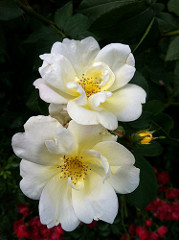

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

## 使用keras 的 preprocess 进行处理

In [8]:
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                        data_dir,
                        validation_split=0.2,
                        subset="training",
                        seed=123,
                        image_size=(img_height, img_width),
                        batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                        data_dir,
                        validation_split=0.2,
                        subset="validation",
                        seed=123,
                        image_size=(img_height, img_width),
                        batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


彩色照片的 RGB 值在0-255，但是我们有的模型输入的时候需要0-1范围的值，我们对这个通道进行处理。有两种方法进行这种操作：
1. 在开始时用 **map** 函数来实现
1. 在模型中增加一层处理
> 如果想让 0-255 变成 -1-1 我们可以用 tf.keras.layers.experimental.preprocessing.Rescaling(1./255， offset=-1)

In [11]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


增加数据集的性能，我们应当关注这两点：
1. cache() 将要训练的数据预先缓存到内存中，防止数据的加载成为训练的瓶颈
2. prefetch() 在模型训练的时候，取数据

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

训练一个模型

In [14]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
model.fit(train_ds)

92/92 [==============================] - 15s 131ms/step - loss: 1.3958 - accuracy: 0.3897


In [17]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
model.fit(train_ds)

92/92 [==============================] - 2s 19ms/step - loss: 0.9957 - accuracy: 0.6155


In [18]:
model.evaluate(val_ds)

23/23 [==============================] - 3s 99ms/step - loss: 0.9514 - accuracy: 0.6240


[0.951430082321167, 0.6239781975746155]

In [19]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predict = probability_model.predict(val_ds)

In [20]:
print([np.argmax(predict[i]) for i in range(32)])
# predict

[0, 3, 3, 0, 3, 4, 0, 2, 2, 0, 1, 1, 0, 3, 4, 3, 3, 0, 3, 3, 1, 3, 4, 1, 1, 3, 1, 1, 1, 2, 1, 3]


tf.Tensor([0 4 3 0 3 4 1 2 4 0 0 0 4 4 4 3 3 0 0 3 1 4 4 2 3 3 1 2 1 2 4 1], shape=(32,), dtype=int32)


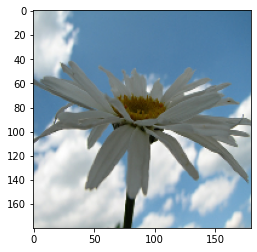

In [21]:
from matplotlib import pyplot as plt
for image, label in val_ds.take(1):
    print(label)
    plt.imshow(image[0].numpy().astype("uint8"))

### 使用 tf.data 进行更加精细的控制

對於更精細的粒度控制，您可以使用 tf.data 編寫自己的輸入管道。本節展示瞭如何做到這一點，從您之前下載的 TGZ 文件中的文件路徑開始。

In [22]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [23]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\lqf_b\\.keras\\datasets\\flower_photos\\sunflowers\\200288046_0032f322ff_n.jpg'
b'C:\\Users\\lqf_b\\.keras\\datasets\\flower_photos\\tulips\\12517756805_56b74be742.jpg'
b'C:\\Users\\lqf_b\\.keras\\datasets\\flower_photos\\tulips\\2813658587_337eeef124_n.jpg'
b'C:\\Users\\lqf_b\\.keras\\datasets\\flower_photos\\daisy\\14354051035_1037b30421_n.jpg'
b'C:\\Users\\lqf_b\\.keras\\datasets\\flower_photos\\daisy\\3695826945_9f374e8a00_m.jpg'


In [24]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [25]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [33]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [34]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [35]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [36]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path)
val_ds = val_ds.map(process_path)

In [37]:
process_path

<function __main__.process_path(file_path)>

In [38]:
train_ds.take(1)

<TakeDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int64)>

In [39]:
print(train_ds)
print(val_ds)

<MapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int64)>


In [40]:
for image, label in train_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2
Image shape:  (180, 180, 3)
Label:  1


### Configure dataset for performance
To train a model with this dataset you will want the data:

+ To be well shuffled.
+ To be batched.
+ Batches to be available as soon as possible.
These features can be added using the`__tf.data API__.`For more details, see the Input Pipeline Performance guide.

In [42]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

TypeError: Invalid shape (32, 180, 180, 3) for image data

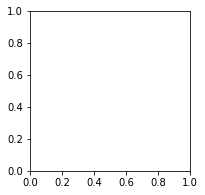

In [44]:
from matplotlib import pyplot as plt
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [45]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


ValueError: in user code:

    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    d:\software\python\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    d:\software\python\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    d:\software\python\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    d:\software\python\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer max_pooling2d is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, None, 178, 178, 32)


In [ ]:
model.evaluate(val_ds)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

In [24]:
image_batch, label_batch = next(iter(train_ds))
image_batch[1].()

TypeError: 'TensorShape' object is not callable

In [1]:
model.predict(image_batch[1])

NameError: name 'model' is not defined